In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product d.csv', parse_dates=['Month-Year'])

In [3]:
sales_d= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_d.shape

(60, 2)

In [5]:
sales_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_d['Sales'].sum()

7173488

In [7]:
sales_d = sales_d.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_d.head()

,ds,y
0,2019-01-01,96684
1,2019-02-01,99187
2,2019-03-01,113711
3,2019-04-01,103982
4,2019-05-01,101826


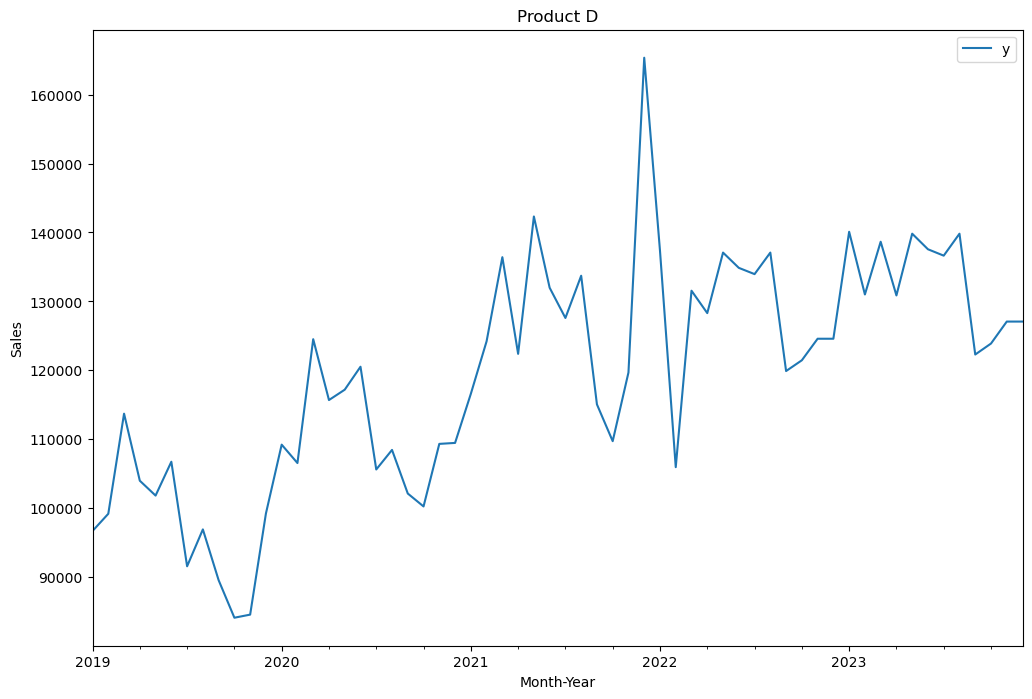

In [8]:
ax = sales_d.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product D')
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adf_test(sales_d['y'])

ADF Statistics: -2.3249460487083105
p- value: 0.16404854202961083
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
train= sales_d[:48]
test=sales_d[48:]

In [13]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=6).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 10, num=6).tolist()

print(changepoint_prior_scale_range)
print(seasonality_prior_scale_range)

[0.001, 0.1008, 0.2006, 0.3004, 0.4002, 0.5]
[0.01, 2.008, 4.006, 6.004, 8.002, 10.0]


# Hyperparameter Tuning

In [ ]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

14:32:06 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] done processing
14:32:11 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing
14:32:22 - cmdstanpy - INFO - Chain [1] done processing
14:32:24 - cmdstanpy - INFO - Chain [1] start processing
14:32:25 - cmdstanpy - INFO - Chain [1] done processing
14:32:28 - cmdstanpy - INFO - Chain [1] start processing
14:32:28 - cmdstanpy - INFO - Chain [1] done processing
14:32:30 - cmdstanpy - INFO - Chain [1] start processing
14:32:31 - cmdstanpy - INFO - Chain [1]

In [222]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,rmse
8,0.010,0.010,15310.188781
0,0.001,0.010,16029.424035
5,0.001,6.004,18114.260370
2,0.001,1.000,18430.942284
9,0.010,0.100,18439.332306
...,...,...,...
60,0.500,4.006,40073.073237
63,0.500,10.000,40084.811315
59,0.500,2.008,40099.525074
58,0.500,1.000,40333.159424


In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [223]:
# Create a Prophet model
model = Prophet(changepoint_prior_scale=0.010, seasonality_prior_scale=0.010, interval_width=0.95)

In [224]:
model.fit(train)

16:07:40 - cmdstanpy - INFO - Chain [1] start processing
16:07:41 - cmdstanpy - INFO - Chain [1] done processing


In [225]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [226]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [227]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [228]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,139602.083184,121896.591181,157177.216864
49,2023-02-01,135435.403381,116803.411886,152975.165217
50,2023-03-01,145818.464298,128429.397541,163335.092662
51,2023-04-01,140565.639318,121986.509635,158792.980003
52,2023-05-01,145484.427416,127511.070611,162114.510319
53,2023-06-01,145685.684263,127065.886726,163739.836787
54,2023-07-01,141440.872629,122342.846053,160056.767756
55,2023-08-01,145119.445861,128201.513605,162084.147025
56,2023-09-01,138618.179487,118956.928240,156348.916374
57,2023-10-01,137595.649143,118336.437317,153958.132607


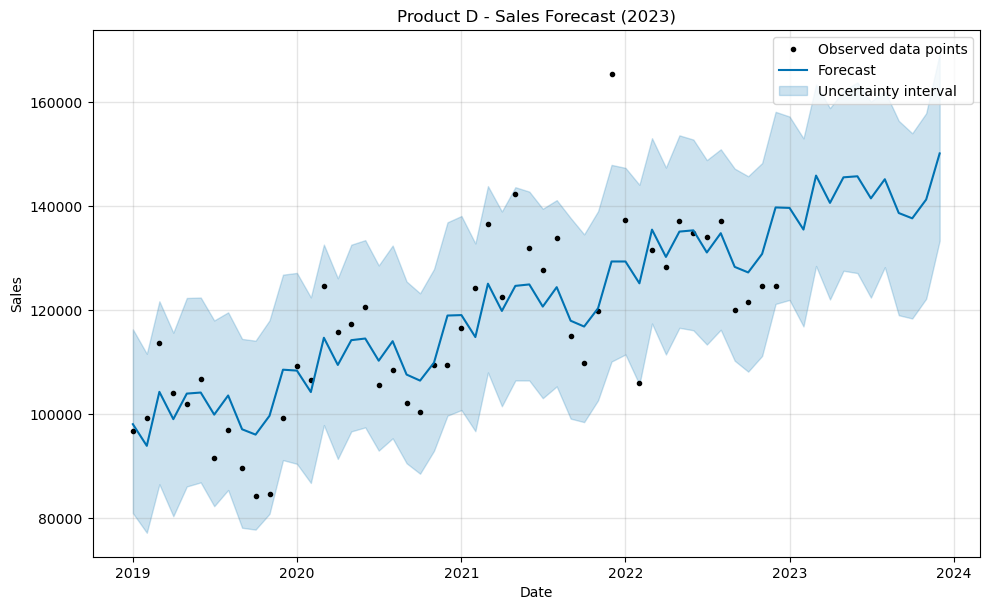

In [229]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product D - Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [ ]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

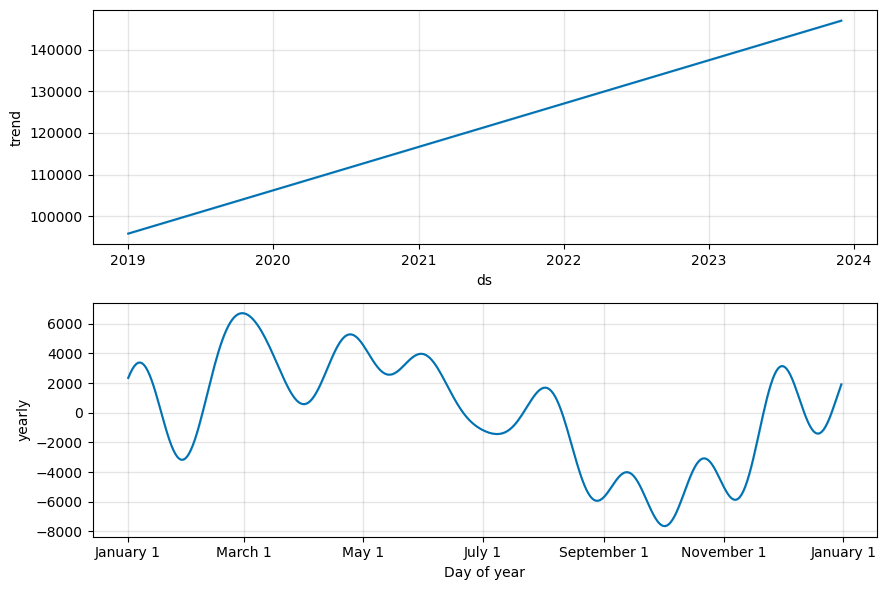

In [230]:
fig2 = model.plot_components(forecast)

In [231]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,139602.083184,121896.591181,157177.216864
49,2023-02-01,135435.403381,116803.411886,152975.165217
50,2023-03-01,145818.464298,128429.397541,163335.092662
51,2023-04-01,140565.639318,121986.509635,158792.980003
52,2023-05-01,145484.427416,127511.070611,162114.510319
53,2023-06-01,145685.684263,127065.886726,163739.836787
54,2023-07-01,141440.872629,122342.846053,160056.767756
55,2023-08-01,145119.445861,128201.513605,162084.147025
56,2023-09-01,138618.179487,118956.928240,156348.916374
57,2023-10-01,137595.649143,118336.437317,153958.132607


In [232]:
sales_d.tail(12) 

,ds,y
48,2023-01-01,140104
49,2023-02-01,131006
50,2023-03-01,138656
51,2023-04-01,130866
52,2023-05-01,139824
53,2023-06-01,137565
54,2023-07-01,136637
55,2023-08-01,139824
56,2023-09-01,122293
57,2023-10-01,123887


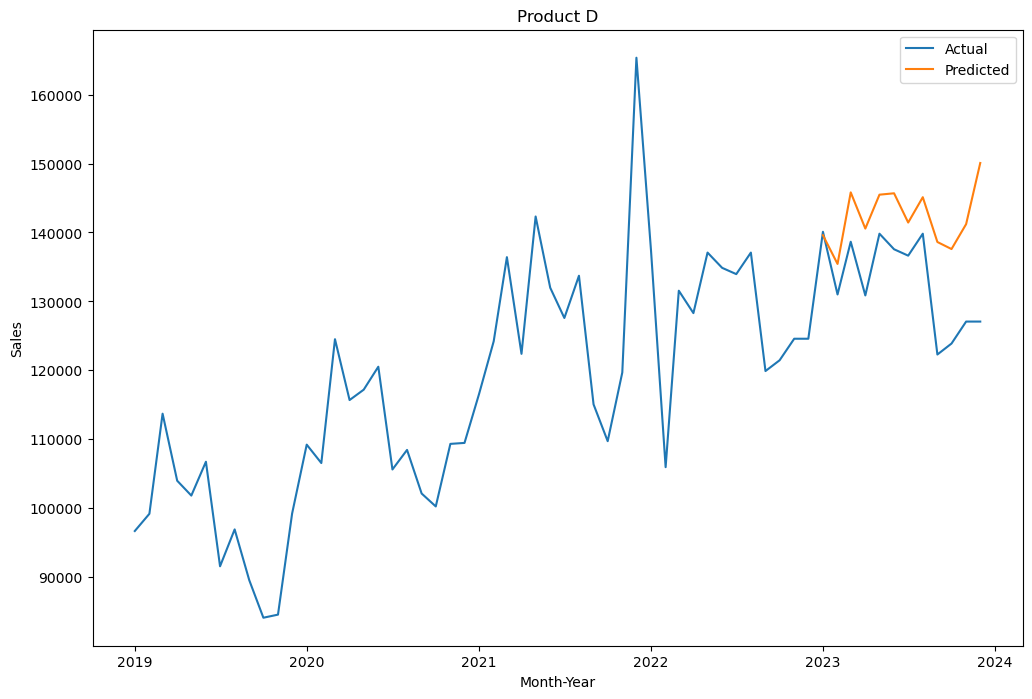

In [233]:
# Reset index of sales_b DataFrame
sales_d_reset_index = sales_d.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_d_reset_index['ds'], sales_d_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product D')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [234]:
#model evaluation

In [235]:
pred=forecasted_df['yhat']
test_df=test['y']

In [236]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 9404.519
MAPE - FB PROPHET: 0.073
MSE - FB PROPHET: 124838660.964
RMSE - FB PROPHET: 11173.122


In [237]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

# Cross Validation

In [238]:
from prophet.diagnostics import cross_validation
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [239]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,5.786382e+06,2405.489940,2405.489940,0.017513,0.017513,0.017667,1.0
1,62 days,8.860056e+08,29765.845873,29765.845873,0.280948,0.280948,0.246343,0.0
2,90 days,1.567772e+08,12521.068894,12521.068894,0.095180,0.095180,0.090856,1.0
3,121 days,1.007272e+08,10036.291869,10036.291869,0.078225,0.078225,0.075281,1.0
4,151 days,3.607988e+07,6006.652567,6006.652567,0.043818,0.043818,0.042878,1.0
5,182 days,8.317246e+07,9119.893824,9119.893824,0.067621,0.067621,0.065409,1.0
6,212 days,2.339080e+07,4836.403197,4836.403197,0.036104,0.036104,0.035464,1.0
7,243 days,3.385083e+07,5818.146605,5818.146605,0.042443,0.042443,0.041561,1.0
8,274 days,3.228484e+08,17967.982957,17967.982957,0.149864,0.149864,0.139417,0.0
9,304 days,2.136555e+08,14616.961033,14616.961033,0.120346,0.120346,0.113515,1.0


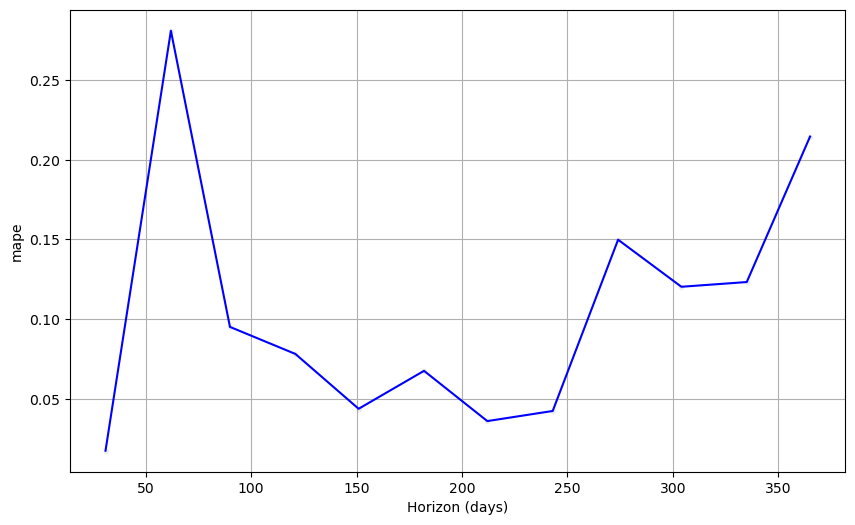

In [240]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')